https://app.pluralsight.com/course-player?clipId=5e039a74-a126-4449-850b-3d7bff379ec9
    
Extract data from http://goo.gl/seiSek

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.\
        appName('london crime report')\
        .getOrCreate()        

In [2]:
london_crime_file = '..\datasets\london_crime_by_lsoa.csv'

In [3]:
data = spark.read\
        .format('csv').option('header','true')\
        .load(london_crime_file)

In [4]:
data.count()

13490604

In [5]:
data.printSchema()

root
 |-- lsoa_code: string (nullable = true)
 |-- borough: string (nullable = true)
 |-- major_category: string (nullable = true)
 |-- minor_category: string (nullable = true)
 |-- value: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)



### Load a subset of dataframe

In [6]:
data.limit(5).show()

+---------+----------+--------------------+--------------------+-----+----+-----+
|lsoa_code|   borough|      major_category|      minor_category|value|year|month|
+---------+----------+--------------------+--------------------+-----+----+-----+
|E01001116|   Croydon|            Burglary|Burglary in Other...|    0|2016|   11|
|E01001646| Greenwich|Violence Against ...|      Other violence|    0|2016|   11|
|E01000677|   Bromley|Violence Against ...|      Other violence|    0|2015|    5|
|E01003774| Redbridge|            Burglary|Burglary in Other...|    0|2016|    3|
|E01004563|Wandsworth|             Robbery|   Personal Property|    0|2008|    6|
+---------+----------+--------------------+--------------------+-----+----+-----+



In [7]:
data.dropna().count()

13490604

## Drop column

In [10]:
data = data.drop('lsoa_code')

data.show(5)

+----------+--------------------+--------------------+-----+----+-----+
|   borough|      major_category|      minor_category|value|year|month|
+----------+--------------------+--------------------+-----+----+-----+
|   Croydon|            Burglary|Burglary in Other...|    0|2016|   11|
| Greenwich|Violence Against ...|      Other violence|    0|2016|   11|
|   Bromley|Violence Against ...|      Other violence|    0|2015|    5|
| Redbridge|            Burglary|Burglary in Other...|    0|2016|    3|
|Wandsworth|             Robbery|   Personal Property|    0|2008|    6|
+----------+--------------------+--------------------+-----+----+-----+
only showing top 5 rows



## Distinct

In [13]:
data.select('borough').distinct().count()

33

In [12]:
data.select('major_category', 'minor_category').distinct().count()

32

## Filter

In [15]:
data.filter(data.borough== 'Hackney').show(5)

+-------+--------------------+--------------------+-----+----+-----+
|borough|      major_category|      minor_category|value|year|month|
+-------+--------------------+--------------------+-----+----+-----+
|Hackney|     Criminal Damage|Criminal Damage T...|    0|2011|    6|
|Hackney|Violence Against ...|          Harassment|    1|2013|    2|
|Hackney|     Criminal Damage|Other Criminal Da...|    0|2011|    7|
|Hackney|Violence Against ...|        Wounding/GBH|    0|2013|   12|
|Hackney|  Theft and Handling|  Other Theft Person|    0|2016|    8|
+-------+--------------------+--------------------+-----+----+-----+
only showing top 5 rows



In [16]:
data.filter(data.year.isin([2016,2015])).show(5)

+---------+--------------------+--------------------+-----+----+-----+
|  borough|      major_category|      minor_category|value|year|month|
+---------+--------------------+--------------------+-----+----+-----+
|  Croydon|            Burglary|Burglary in Other...|    0|2016|   11|
|Greenwich|Violence Against ...|      Other violence|    0|2016|   11|
|  Bromley|Violence Against ...|      Other violence|    0|2015|    5|
|Redbridge|            Burglary|Burglary in Other...|    0|2016|    3|
|   Sutton|  Theft and Handling|Theft/Taking of P...|    1|2016|    8|
+---------+--------------------+--------------------+-----+----+-----+
only showing top 5 rows



## Sample

In [18]:
data.count() / data.sample(0.1).count()

9.98042031298203

## Aggregation
Convictions by borough in descending order

In [91]:
import pyspark.sql.functions as F

data = data.withColumn('value',F.col('value').cast(DoubleType()))
data.printSchema()

root
 |-- borough: string (nullable = true)
 |-- major_category: string (nullable = true)
 |-- minor_category: string (nullable = true)
 |-- value: double (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)



In [92]:

convictions_borough = data.groupBy('borough')\
                        .agg(F.sum('value'))\
                        .withColumnRenamed('sum(value)', 'convictions')\
                        .orderBy(F.col('convictions').desc())
convictions_borough.show(5)

+-----------+-----------+
|    borough|convictions|
+-----------+-----------+
|Westminster|   455028.0|
|    Lambeth|   292178.0|
|  Southwark|   278809.0|
|     Camden|   275147.0|
|     Newham|   262024.0|
+-----------+-----------+
only showing top 5 rows



## Describe

In [94]:
data.select('year').describe().show()

+-------+------------------+
|summary|              year|
+-------+------------------+
|  count|          13490604|
|   mean|            2012.0|
| stddev|2.5819889931674522|
|    min|              2008|
|    max|              2016|
+-------+------------------+



## Crosstab
Computes a pair-wise frequency table of the given columns.

In [96]:
data.crosstab('borough','major_category').show(5)

+----------------------+--------+---------------+-----+----------------+-------------------------+-------+---------------+------------------+---------------------------+
|borough_major_category|Burglary|Criminal Damage|Drugs|Fraud or Forgery|Other Notifiable Offences|Robbery|Sexual Offences|Theft and Handling|Violence Against the Person|
+----------------------+--------+---------------+-----+----------------+-------------------------+-------+---------------+------------------+---------------------------+
|              Havering|   32400|          64152|32616|            5508|                    21060|  27648|           1944|            118800|                      95472|
|                Merton|   26784|          52920|29160|            5724|                    19440|  23652|           2592|            101196|                      78408|
|              Haringey|   31320|          62424|35424|           10368|                    23760|  29484|           3780|            120420|         

## Plot

In [100]:
import matplotlib.pyplot as pp
pp.style.use('ggplot')

In [114]:
def describe_year(year):
    year_data = data.filter(F.col('year')==year)\
                .groupBy('borough')\
                .agg(F.sum('value').alias('convictions'))
    borough_list = [r[0] for r in year_data.toLocalIterator()]
    conviction_list = [r[1] for r in year_data.toLocalIterator()]
    
    pp.figure(figsize = (33,10))
    pp.bar(borough_list,conviction_list)
    
    pp.title('Crime for the year : {}'.format(year), fontsize = 30)
    pp.xlabel('Boroughs', fontsize = 30)
    pp.ylabel('Total Convictions',fontsize = 30)
    
    pp.xticks(rotation = 90, fontsize = 30)
    pp.yticks( fontsize = 30)
    pp.autoscale()
    pp.show()


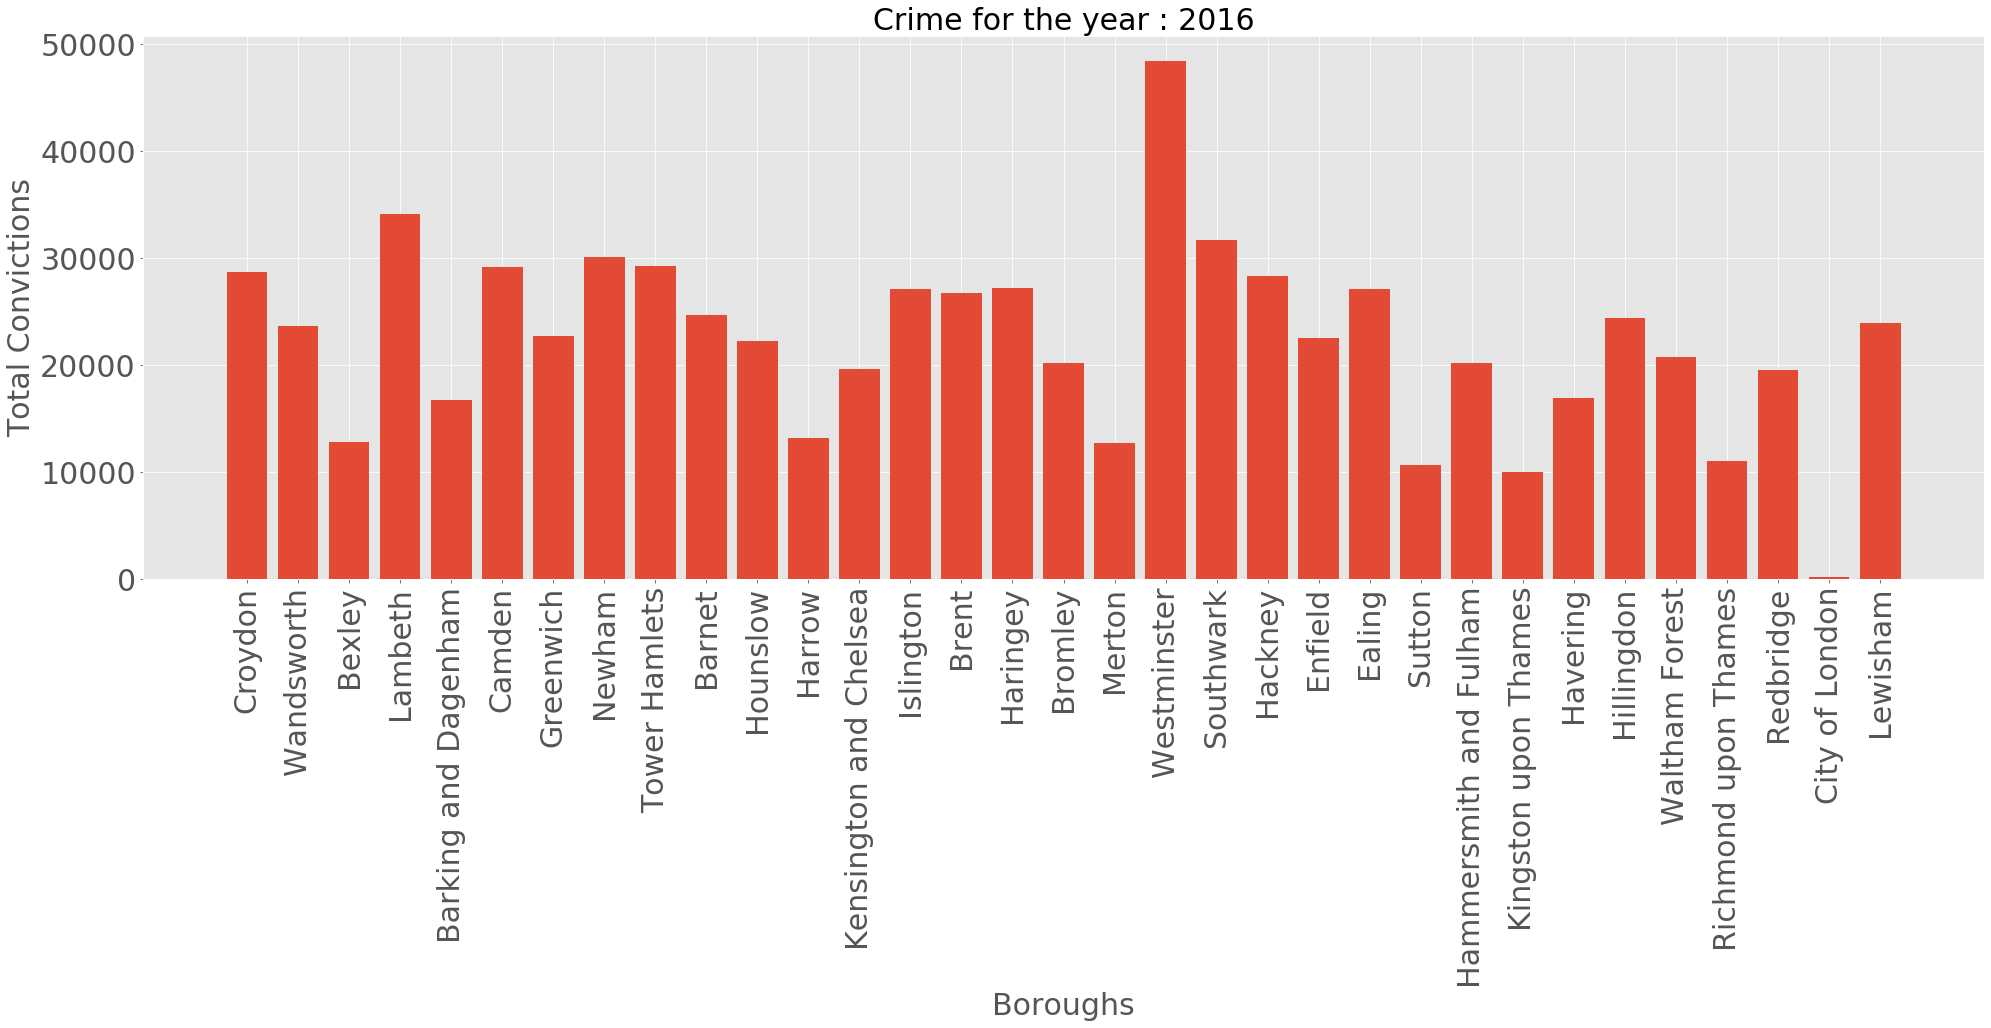

In [115]:
describe_year(2016)